In [1]:
!pip install AugmentedSocialScientist pandas numpy wordcloud matplotlib spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 9.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 5.5 MB/s eta 0:00:00:

# Description des annotations

## Description des catégories en nombre et recodage

In [2]:
import pandas as pd
simplify_labels = True

annotations_file = pd.read_csv("../data/intermediate/current_annotation_file.csv")
# defining the label variable, with a possible recategorization before training
label_categories = {
    "Poubelle" : "Anything but personne à protéger",
    "Humain comme empathie" : "Anything but personne à protéger",
    "Genre/espèce humaine": "Anything but personne à protéger",
    "Matériel biologique": "Anything but personne à protéger",
    "Individu": "Anything but personne à protéger",
    "Agent responsable":"Anything but personne à protéger",
    "Personne relationnelle": "Anything but personne à protéger",
    "Personne à protéger":"Personne à protéger"

}

if(simplify_labels):
    annotations_file['label'] = annotations_file['Personne'].map(label_categories)
else:
    annotations_file['label'] = annotations_file['Personne']

# defining text variable    
annotations_file['text'] = annotations_file['sentence_text']


annotations_file.sample(5)

,sentence_id,Personne,sentence_text,label,text
1240,80005,NaN,Définition de l'embryon\nL'embryon humain in v...,NaN,Définition de l'embryon\nL'embryon humain in v...
144,80557,Matériel biologique,"Enfin et\nsurtout, compte tenu d'un contexte s...",Anything but personne à protéger,"Enfin et\nsurtout, compte tenu d'un contexte s..."
960,870258,NaN,"Un refus de traitement est, donc, toujours au ...",NaN,"Un refus de traitement est, donc, toujours au ..."
1405,1280929,NaN,La situatio n ne donne plus la capacité aux in...,NaN,La situatio n ne donne plus la capacité aux in...
1251,380068,NaN,La sécurité. Le coût humain\nDans la recherche...,NaN,La sécurité. Le coût humain\nDans la recherche...


In [3]:
# filtering out not annotated (na) and some categories
annotations = annotations_file.dropna()
annotations = annotations[~annotations["Personne"].isin(["Poubelle"])]
annotations.sample(5)

,sentence_id,Personne,sentence_text,label,text
167,1250289,Genre/espèce humaine,18 L’être humain vit dans un écosystème comple...,Anything but personne à protéger,18 L’être humain vit dans un écosystème comple...
271,1360033,Personne relationnelle,Renforcer la formation initiale et continue de...,Anything but personne à protéger,Renforcer la formation initiale et continue de...
49,140535,Personne à protéger,Une étude comparative du rendement d'un dépist...,Personne à protéger,Une étude comparative du rendement d'un dépist...
87,1440124,Personne relationnelle,Cadre de la réflexion éthique sur les enjeux d...,Anything but personne à protéger,Cadre de la réflexion éthique sur les enjeux d...
328,1020347,Personne à protéger,6) Il est illusoire de favoriser l’insertion ...,Personne à protéger,6) Il est illusoire de favoriser l’insertion ...


In [4]:
annotations["Personne"].value_counts()

Personne
Personne à protéger       143
Matériel biologique       127
Individu                  118
Agent responsable         104
Personne relationnelle     97
Genre/espèce humaine       90
Humain comme empathie      10
Name: count, dtype: int64

In [5]:
annotations["label"].value_counts()

label
Anything but personne à protéger    546
Personne à protéger                 143
Name: count, dtype: int64

## Description lexicographique

In [18]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the French language model from spaCy
nlp = spacy.load("fr_core_news_sm")

# Function to lemmatize text
def lemmatize_text(text):
    custom_stop_words = ["e"]
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token in custom_stop_words])
    return lemmatized

# Apply lemmatization to the 'text' column
annotations['lemmatized_text'] = annotations['text'].apply(lemmatize_text)

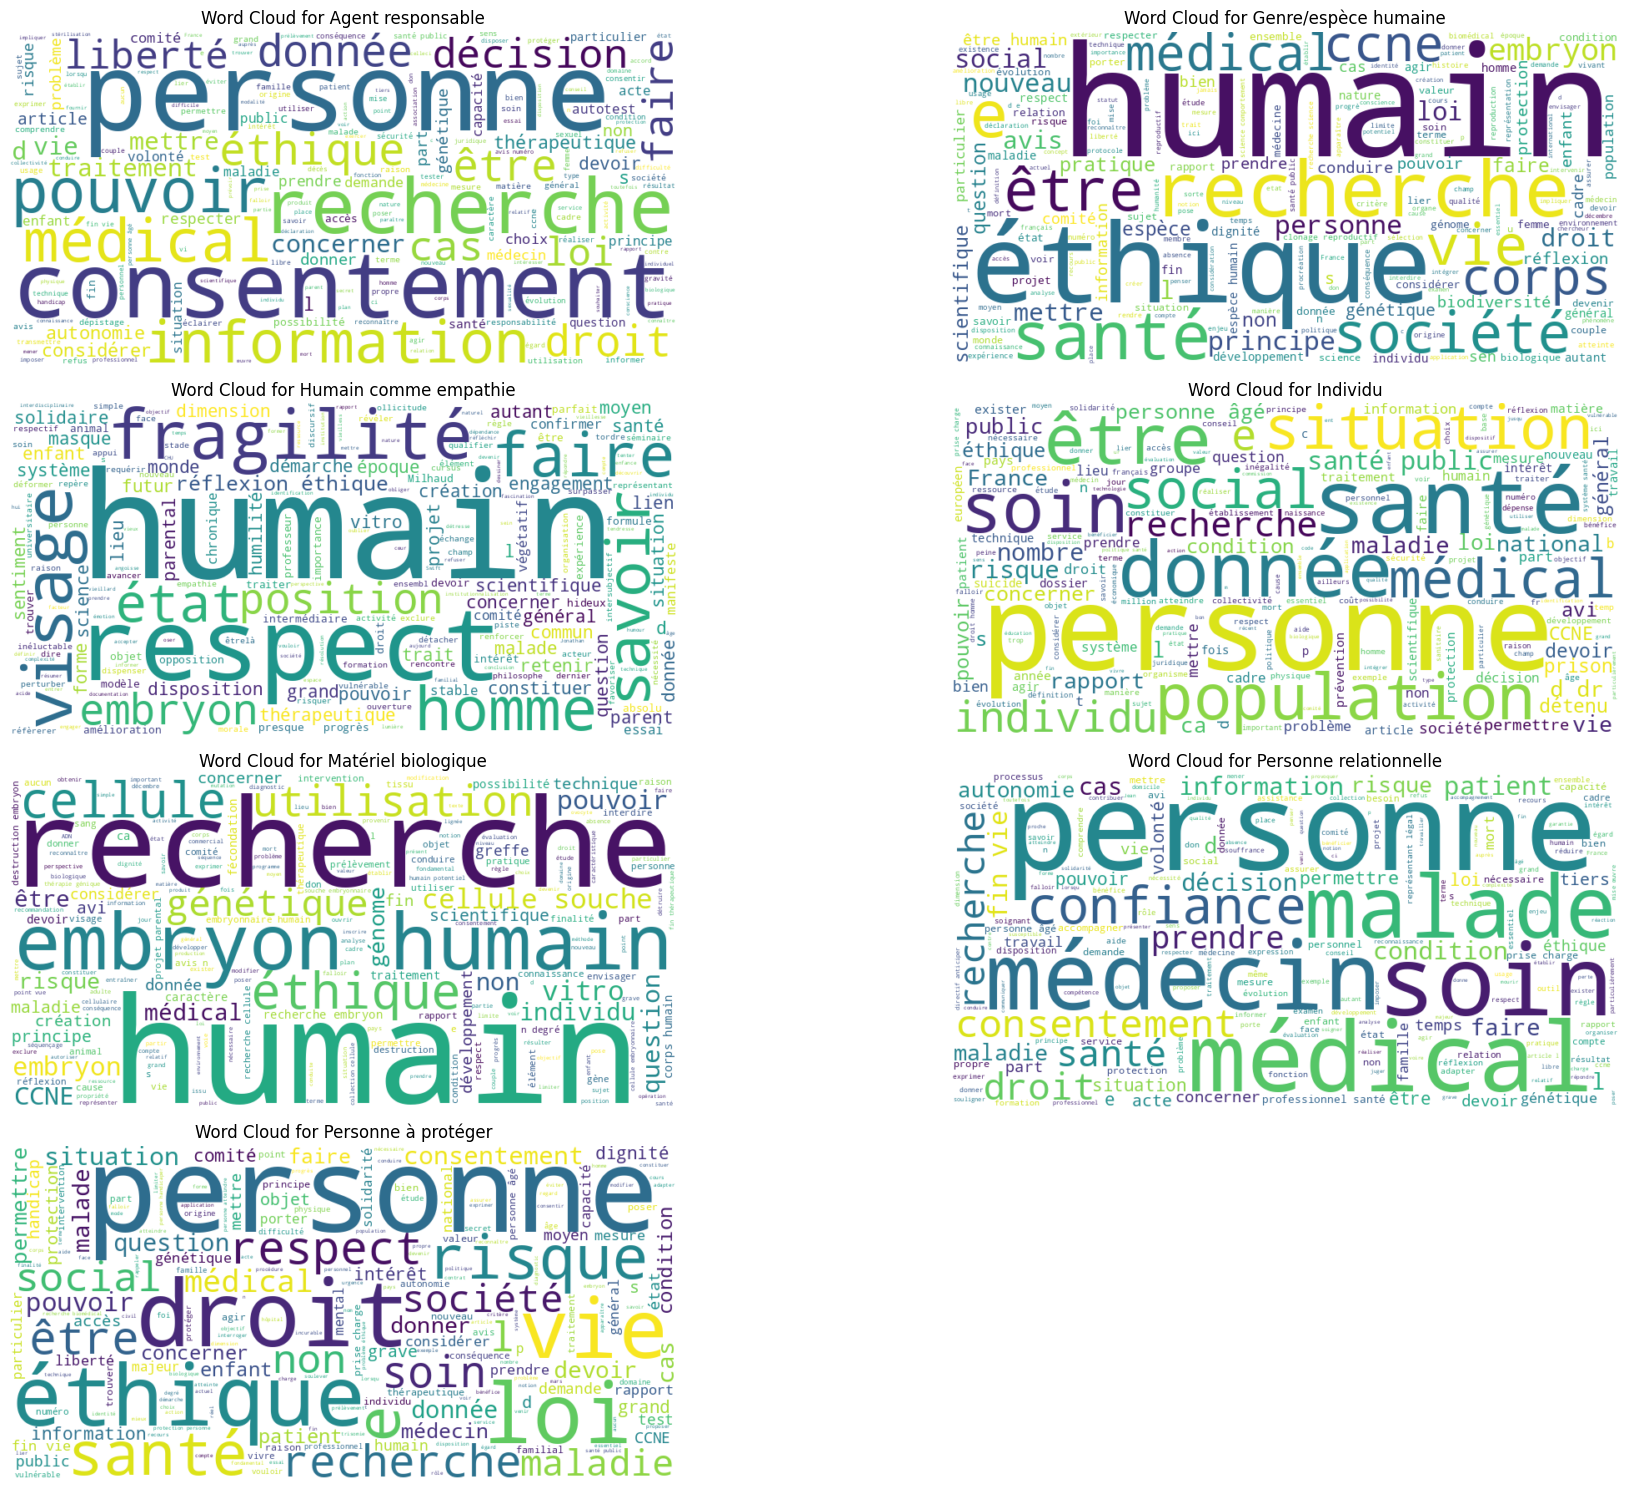

In [19]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Determine the number of categories
num_categories = annotations['Personne'].nunique()

# Setup plot grid (2 columns, 3 rows max)
cols = 2
rows = round(num_categories/cols)
# Create the figure with a gridspec
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(rows, cols, figure=fig)

# Counter for subplot index
subplot_index = 0

for category, group in annotations.groupby('Personne'):
    combined_text = " ".join(group['lemmatized_text'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)
    
    # Calculate row, col index for the current subplot
    row = subplot_index // cols
    col = subplot_index % cols
    
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {category}')
    ax.axis('off')
    
    subplot_index += 1

plt.tight_layout()
plt.show()

# Bert classification

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda

cuda.get_device_name(0)

'Tesla T4'

In [7]:
from sklearn.model_selection import train_test_split
 
train_data, test_data = train_test_split(annotations, train_size=0.80)

In [8]:
from AugmentedSocialScientist.models import Camembert

bert = Camembert()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


There are 1 GPU(s) available.
We will use GPU 0: Tesla T4


In [9]:
batch_size = 16
train_loader = bert.encode(train_data.text.values,
train_data.label.values, batch_size=batch_size)

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

label ids: {'Anything but personne à protéger': 0, 'Personne à protéger': 1}


In [10]:
test_loader = bert.encode(test_data.text.values,
test_data.label.values, batch_size=batch_size)

  0%|          | 0/138 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/138 [00:00<?, ?it/s]

label ids: {'Anything but personne à protéger': 0, 'Personne à protéger': 1}


In [11]:
scores = bert.run_training(
    train_loader,
    test_loader,
    n_epochs=3,
    lr=2e-5,
    random_state=42,
    save_model_as='clickbait'
    )

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/mamba/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.53
  Training took: 0:00:43

Running Validation...

  Average test loss: 0.57
  Validation took: 0:00:04
                                  precision    recall  f1-score   support

Anything but personne à protéger       0.75      1.00      0.86       104
             Personne à protéger       0.00      0.00      0.00        34

                        accuracy                           0.75       138
                       macro avg       0.38      0.50      0.43       138
                    weighted avg       0.57      0.75      0.65       138


======== Epoch 2 / 3 ========
Training...


/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m


  Average training loss: 0.49
  Training took: 0:00:44

Running Validation...

  Average test loss: 0.57
  Validation took: 0:00:04
                                  precision    recall  f1-score   support

Anything but personne à protéger       0.75      1.00      0.86       104
             Personne à protéger       0.00      0.00      0.00        34

                        accuracy                           0.75       138
                       macro avg       0.38      0.50      0.43       138
                    weighted avg       0.57      0.75      0.65       138


======== Epoch 3 / 3 ========
Training...


/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m


  Average training loss: 0.49
  Training took: 0:00:46

Running Validation...

  Average test loss: 0.57
  Validation took: 0:00:05
                                  precision    recall  f1-score   support

Anything but personne à protéger       0.75      1.00      0.86       104
             Personne à protéger       0.00      0.00      0.00        34

                        accuracy                           0.75       138
                       macro avg       0.38      0.50      0.43       138
                    weighted avg       0.57      0.75      0.65       138


Training complete!


/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

In [12]:
import numpy as np
pred_data = annotations_file[annotations_file["label"].isna()][["text"]].dropna()
pred_loader = bert.encode(pred_data.text.values, batch_size=batch_size)
pred_proba = bert.predict_with_model(pred_loader, model_path='./models/clickbait')
pred_data['pred_label'] = np.argmax(pred_proba, axis=1)
pred_data['pred_proba'] = np.max(pred_proba, axis=1)

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

label ids: {'Anything but personne à protéger': 0, 'Personne à protéger': 1}


In [13]:
pred_data["pred_proba"].describe()

count    798.000000
mean       0.827895
std        0.005984
min        0.803698
25%        0.824069
50%        0.828583
75%        0.832703
max        0.841079
Name: pred_proba, dtype: float64

In [14]:
pd.set_option('display.max_colwidth', None)  # Use None to show all the text, or set a large number

pred_data

,text,pred_label,pred_proba
700,"S’il semble dès lors naïf de penser que le sentiment de soi est dépendant \nd’une augmentation ou d’une diminution quelconque, on ne peut en revanche exclure que ce sentiment \npuisse être modifié quand un seuil technique, par la prise régulière et prolongée de médicaments \nnotamme nt, est franchi. Il importe donc de tenir compte de toutes les modifications du comportement \nd’une personne quand on veut évaluer les processus dits « internes » liés au sentiment de soi 91. En raison du manque d’études d’observation au long cours sur la ne uroamélioration (IIIb), la \nquestion reste posée du risque éventuel de modification de capacités premières, relatives au soi, de la \npersonne humaine comme « être en bonne santé, vivre longtemps, avoir une bonne mémoire, être \nd’une humeur égale, ne pas être durablement dans des états affectifs paralysants comme la timidité ou \nla peur » (B.Baertschi, 2011).",0,0.833727
701,"Personne ne soutient qu'il soit possible de tourner ce droit des parents pour entreprendre\ndes recherches sur l'embryon. Mais, ici encore, la question primaire, celle du principe de\ntelles recherches, suscitera sans doute des oppositions passionnées entre ceux qui\nvoudraient rendre les recherches impossibles et ceux qui n'ont aucune objection à ce\nqu'elles soient menées avec l'accord des personnes qui ont donné vie à l'embryon, par des\néquipes connues et sérieuses qui en garantiraient la destination. Par ailleurs, il ne saurait être question de refuser un statut juridique aux enfants nés d'une\nfécondation artificielle.",0,0.829608
702,"Le temps de parole doit être suffisant pour \nque le mineur éventuel puisse, dans une relation avec l’expert faite de confiance, d’ouverture \nd’esprit et de dialogue, saisir non seulement les raisons de la demande d’examen mais en \nmême temps le caractère aléatoire de ses résultats. 4 - Ces examens médicaux sont actuellement pratiqués en l’absence de consentement de la \npersonne ellemême ou d’un tuteur ou d’une personne de référence. Ils ne peuvent être \nprescrits et réalisés que dans le respect attentif de la personne qui se réclame du statut de \nmineur.",0,0.830974
703,"»\n24 Avis N°107 du 15 octobre 2009 sur les problèmes éthiques liés aux diagnostics anténatals : le diagnostic \nprénatal (DPN) et le diagnostic préimplantatoire (DPI) . 25 Dans l’Avis N°8 du 15 décembre 1986 relatif aux recherches et utilisation des embryons humains in vitro à des \nfins médicales et scientifiques : « Le Comité constate que le développement de la procréation par la fécondation \nin vitro accentue la tendance à réduire les corps humains à l’état d’instruments ; de plus, des techniques telles \nque la congélation des embryons renforcent le caractère artificiel de la reproduction, notamment par la \ndissociation entre la fécondation et la gestation. […] On peut envisager et souhaiter que la recherche permette à \nl’avenir de ne féconder que des ovocytes destinés à être transplantés en vue de la naissance d’un enfant.",0,0.835132
704,"Sur la question du champ d'application de la loi, ils recommandent en\nl'argumentant, "" l'extension du champ de la loi à toute recherche scientifique sur\nl'être humain"" . N° 41 : La Coopération dans le domaine de la recherche biomédicale entre équipes\nfrançaises et équipes de pays en voie de développement économique, 1993\nConsidérant que "" les projets de recherche biomédicale entre les équipes françaises et les\néquipes de pays en voie de développement économique exigent des précautions\nparticulières afin que soient garanties la dignité et la sécurité des personnes se prêtant à\nces recherches d'intérêt général"" , le CCNE déclare : "" Tous les projets doivent être\nsoumis, avant que d'être entrepris, à un Comité spécialisé à créer (Comité\nconsultatif français de protection des personnes se prêteant à la recherche\nbiomédicale dans les pays en voie de développement, ou CCPPVD). Ce Comité spécialisé doit notamment inclure des